## Importing Dependencies

In [27]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.13.0


## Loadind Data into data frame

In [28]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-04-20')

# This script fetches the daily stock prices of Apple Inc. from January 1, 2020, to April 20, 2024

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349159,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200


## Handling Missing Values

In [29]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

## Normalization of Data

In [30]:
# Normalization of Data : Applying Min-Max Scaling: This scales the dataset so that all the input features lie between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

## DATA Transformation to Sequence Format

In [31]:
#LSTM models require input to be in a sequence format. We are transforming the data into sequences for the model to learn from.
#Defining Sequence Length: Choosing a sequence length (60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

## Train-Test Split
Split the data into training and testing sets to evaluate the model’s performance properly.

In [32]:
#Defining Split Ratio: Typically, 80% of data is used for training and 20% for testing.

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Reshaping Data for LSTM

In [33]:
# we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers.
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the LSTM with Attention Model

**Creating LSTM Layers
Our LSTM model will consist of several layers, including LSTM layers for processing the time-series data. The basic structure is as follows**

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

#In this model, units represent the number of neurons in each LSTM layer. 
#return_sequences=True is crucial in the first layers to ensure the output includes sequences, which are essential for stacking LSTM layers. 
#The final LSTM layer does not return sequences as we prepare the data for the attention layer.

## Integrating the Attention Mechanism

In [35]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

**This custom layer computes a weighted sum of the input sequence, allowing the model to pay more attention to certain time steps**

## Optimizing the Model

**To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.**

In [36]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

#Dropout helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training.
#Batch Normalization stabilizes the learning process.

## Model Compilation

**compile the model with an optimizer and loss function suited for our regression task.**

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

#adam optimizer is generally a good choice for recurrent neural networks, and mean squared error works well as a loss function for regression tasks.

## Model Summary

**to understand its structure and number of parameters, we are viewing the model summary**

In [38]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute_2 (Permute)         (None, 50, 60)            0         
                                                                 
 reshape_2 (Reshape)         (None, 50, 60)            0         
                                                                 
 permute_3 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 3000)             

## Training the Model

**LSTM model with attention is built, it’s time to train it using our prepared training set**

In [39]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
27/27 [==============================] - 4s 41ms/step - loss: 0.4855 - val_loss: 0.4530
Epoch 2/100
27/27 [==============================] - 1s 23ms/step - loss: 0.2820 - val_loss: 0.4302
Epoch 3/100
27/27 [==============================] - 1s 23ms/step - loss: 0.2501 - val_loss: 0.4069
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 0.2292 - val_loss: 0.3516
Epoch 5/100
27/27 [==============================] - 1s 23ms/step - loss: 0.2074 - val_loss: 0.3361
Epoch 6/100
27/27 [==============================] - 1s 24ms/step - loss: 0.1820 - val_loss: 0.3050
Epoch 7/100
27/27 [==============================] - 1s 23ms/step - loss: 0.1619 - val_loss: 0.2852
Epoch 8/100
27/27 [==============================] - 1s 22ms/step - loss: 0.1480 - val_loss: 0.2556
Epoch 9/100
27/27 [==============================] - 1s 23ms/step - loss: 0.1310 - val_loss: 0.2271
Epoch 10/100
27/27 [==============================] - 1s 22ms/step - loss: 0.1152 - val_loss: 0.2077

**Here, we train the model for 100 epochs with a batch size of 25. The validation_split parameter reserves a portion of the training data for validation, allowing us to monitor the model's performance on unseen data during training.**

## Handling Overfitting

**Overfitting occurs when a model learns patterns specific to the training data, which do not generalize to new data. Here are ways to avoid overfitting:

**Validation Set: Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data.**
**Early Stopping: This technique stops training when the model’s performance on the validation set starts to degrade. Implementing early stopping in Keras is straightforward:**

In [40]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 1s 29ms/step - loss: 0.0102 - val_loss: 0.0021
Epoch 2/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0083 - val_loss: 0.0129
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0107 - val_loss: 0.0024
Epoch 5/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0104 - val_loss: 0.0015
Epoch 6/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 7/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0094 - val_loss: 0.0017
Epoch 8/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0099 - val_loss: 0.0012
Epoch 9/100
27/27 [==============================] - 1s 26ms/step - loss: 0.0102 - val_loss: 0.0018
Epoch 10/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0137 - val_loss: 0.0084

**Here, patience=10 means training will stop if the validation loss does not improve for 10 consecutive epochs.
Regularization Techniques: Techniques like Dropout and Batch Normalization, which are already included in our model, also help in reducing overfitting**

In [41]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 1s 25ms/step - loss: 0.0125 - val_loss: 0.0078 - lr: 0.0010
Epoch 2/100
 7/27 [======>.......................] - ETA: 0s - loss: 0.0111

C:\Users\drshaheed\anaconda3\envs\pycaret\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 23ms/step - loss: 0.0078 - val_loss: 0.0183 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0101 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0104 - val_loss: 0.0029 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0110 - val_loss: 0.0023 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0077 - val_loss: 0.0140 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0091 - val_loss: 0.0059 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0092 - val_loss: 0.0054 - lr: 0.0010
Epoch 9/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0082 - val_loss: 0.0165 - lr: 0.0010
Epoch 10/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0120 - val_loss: 0.0020 - lr: 0

## Evaluating Model Performance

In [42]:
#Evaluating with the Test Set
#To evaluate the model, we first need to prepare our test data (X_test) in the same way we did for the training data. 
#Then, we can use the model's evaluate function:

# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

7/7 [==============================] - 0s 10ms/step - loss: 0.0055
Test Loss:  0.005522994790226221


## Performance Metrics

**For regression tasks like ours, common metrics include:**

**1. Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction.**


**2. Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.**

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

7/7 [==============================] - 1s 9ms/step
Mean Absolute Error:  0.06965086696762926
Root Mean Square Error:  0.07431685730347871


## Predicting the Next 4 Candles

**Having trained and evaluated our LSTM model with an attention mechanism, the final step is to utilize it for predicting the next 4 candles (days) of AAPL stock prices.**

In [44]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 18ms/step
Predicted Stock Prices for the next 4 days:  [[169.9391]]


**Let’s predict the price for the next 4 days:**

In [45]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
Predicted Stock Prices for the next 4 days:  [169.9391, 170.1527, 171.29424, 172.71075]


## Visualization of Predictions
**Comparing the predicted values with actual stock prices visually can be very insightful. Below is the code to plot the predicted stock prices against the actual data:**

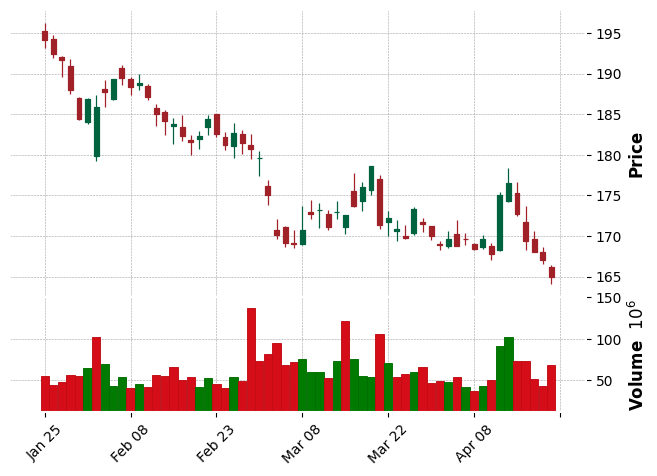

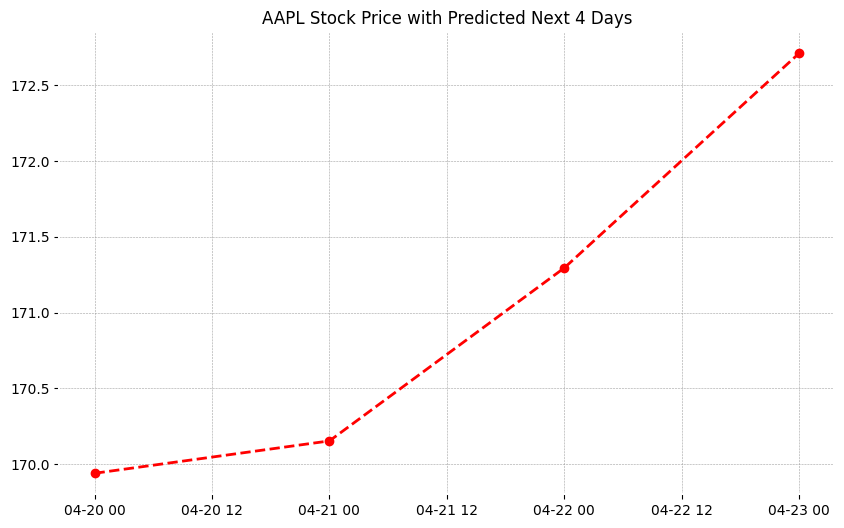

In [46]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

## Final Visual for Predictions:

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


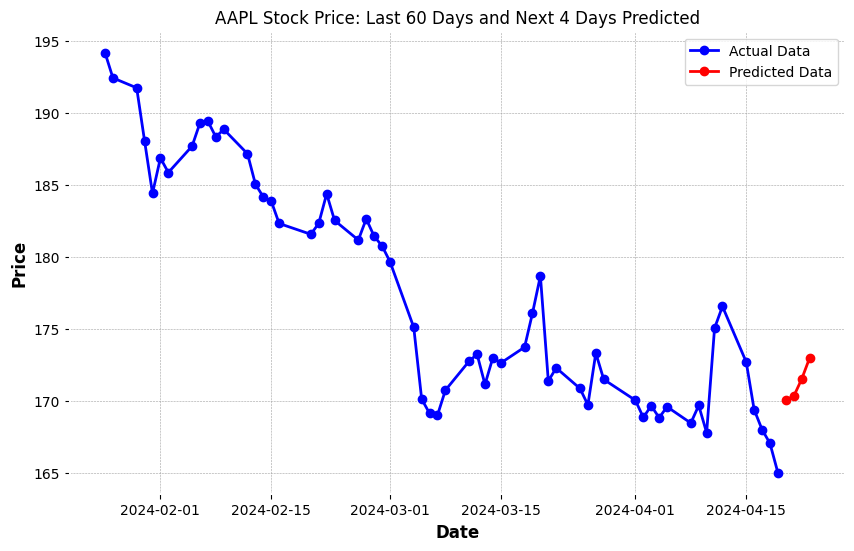

In [47]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()